In [1]:
from LC12b import *

In [2]:
seen_classes = [0, 1, 2]
unseen_class = 3

Dist = (
    {'label': 0, 'prob': 0.1, 'mean': [0, 0], 'cov': [[9, 0], [0, 9]]},
    {'label': 1, 'prob': 0.1, 'mean': [6, 9], 'cov': [[9, 0], [0, 9]]},
    {'label': 2, 'prob': 0.1, 'mean': [12, 0], 'cov': [[9, 0], [0, 9]]},
    {'label': 3, 'prob': 0.7, 'mean': [6, 4.5], 'cov': [[9, 0], [0, 9]]})


# Analysis Module

In [3]:
gu = guruCalc(Dist, seen_classes)

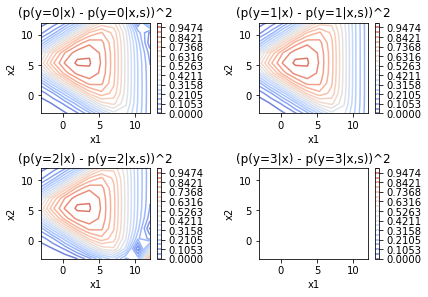

0.0724416545368
0.165296435767
0.0655687681953
0.404684966582


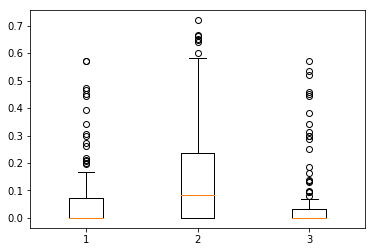

In [4]:
# Find where we can see the largest differences

diff, rel_diff = gu.posterior_diff(row_lim=(-3, 12), col_lim=(-3, 12), res=10)

# diff : list of 4 of [res x res]
for d in diff:
    print(np.average(d))

# Turn diff to 2D array of 4 x (res*res)
adiff = np.array([diff[0].ravel(), diff[1].ravel(), diff[2].ravel()])

# multiple box plots on one figure
plt.figure()
plt.boxplot(np.transpose(adiff))
plt.show()


In [12]:
import matplotlib
matplotlib.__version__

'2.0.2'

Therefore, where we get it wrong is where we will see the largest difference (where unseen locates)

Explore calculated probs

p(y)
p(y=0) = 0.2
p(y=1) = 0.2
p(y=2) = 0.2
p(y=3) = 0.4
p(x|y)


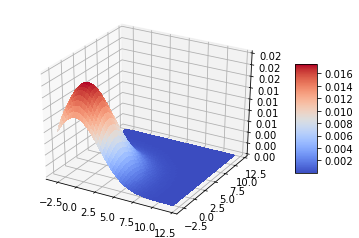

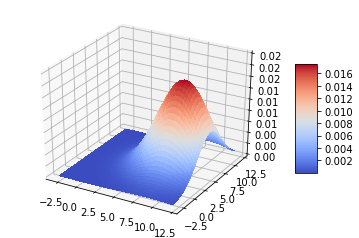

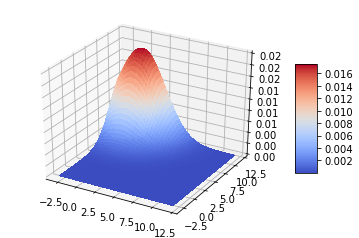

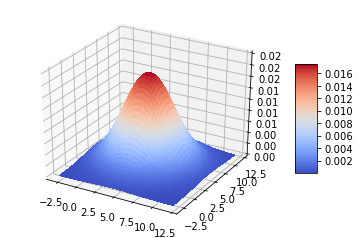

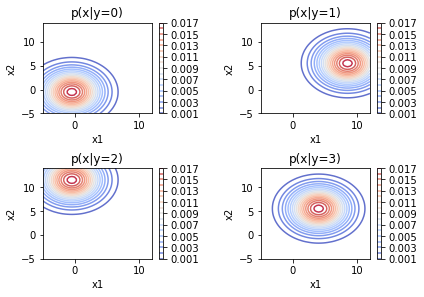

p(x)


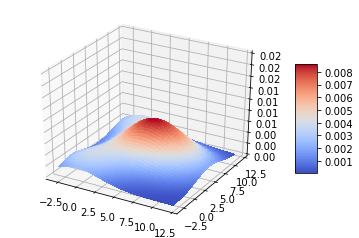

p(s)
0.6000000000000001
p(x|s)


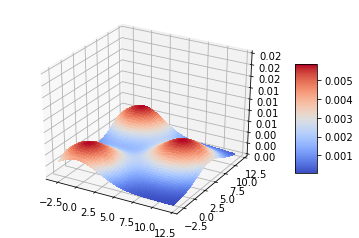

p(x,y)


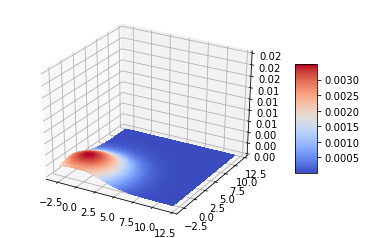

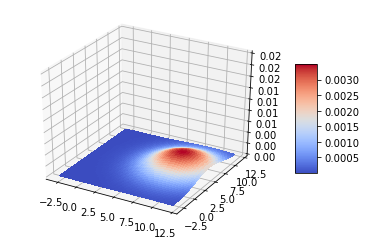

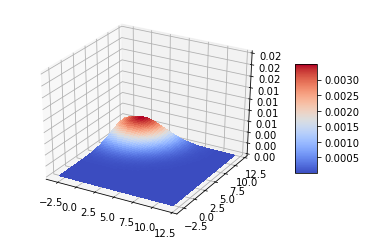

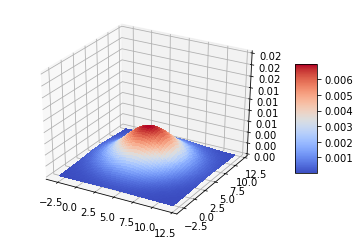

p(x,y|s)


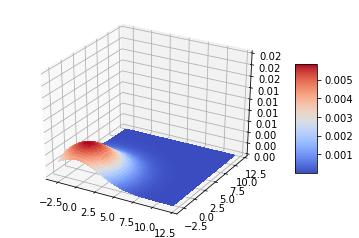

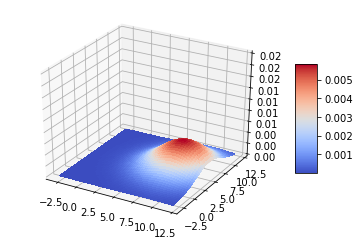

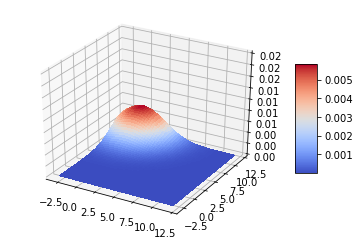

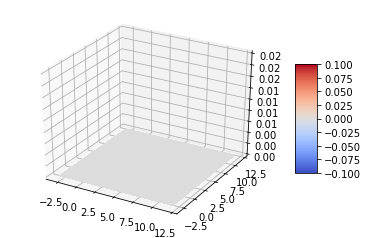

p(y|x


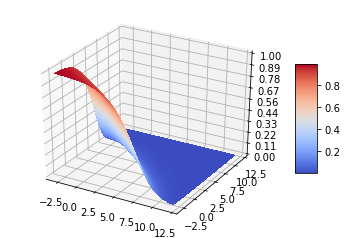

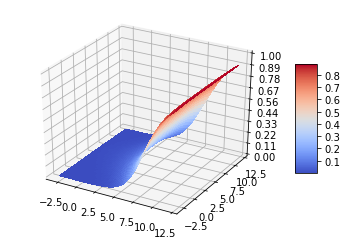

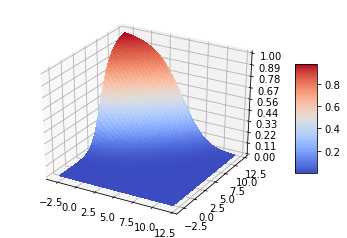

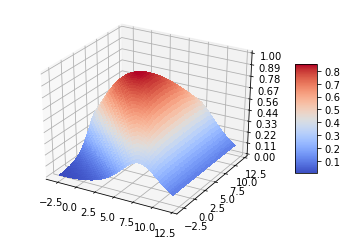

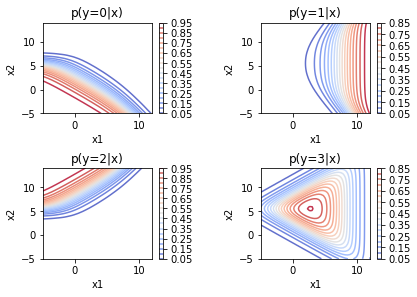

p(y|x,s


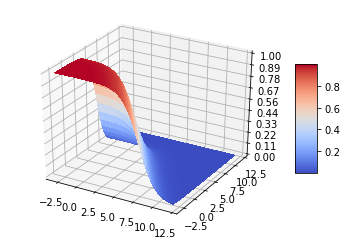

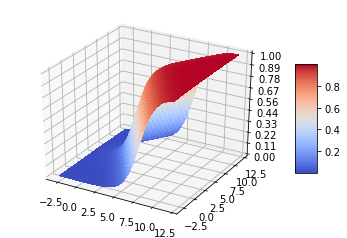

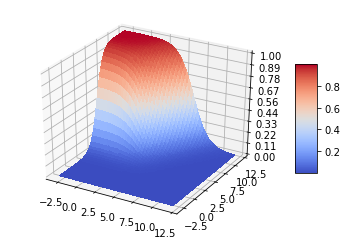

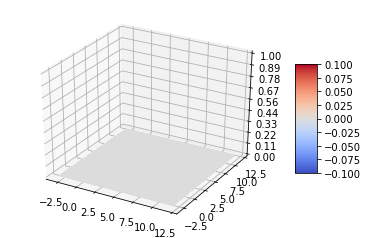

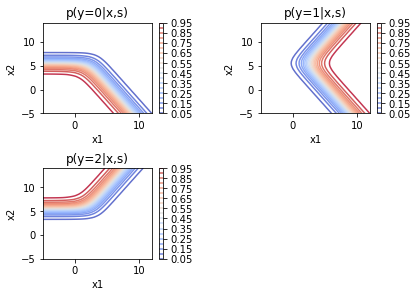

In [13]:
gu.explore_probs()

# Simulation Module

In [5]:
gs = guruSim(Dist, seen_classes)

# train (seen) =  1500
# unseen in train_y: False
# test =  501
# unseen in test_y: False


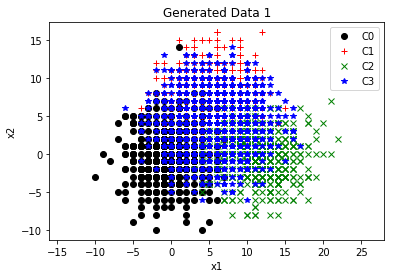

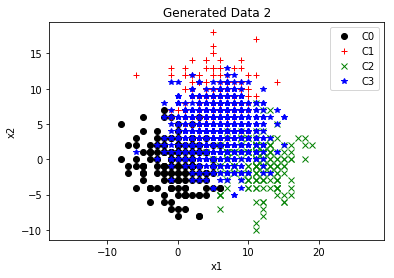

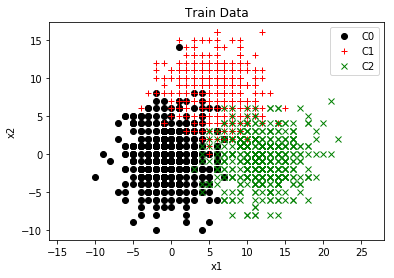

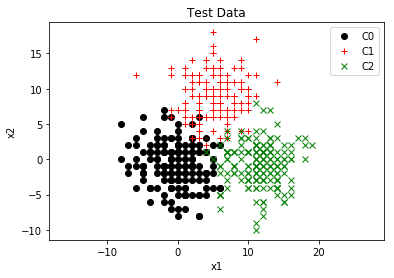

In [6]:
gs.prepare_data(1500, 500)
gs.plot_data2D(gs.All_Data[0], title='Generated Data 1')
gs.plot_data2D(gs.All_Data[1], title='Generated Data 2')
gs.plot_Data(gs.Train_Data, title='Train Data')
gs.plot_Data(gs.Test_Data, title='Test Data')


# Build and train a model

In [7]:
# Define model
model = keras.Sequential([
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(3, activation=tf.nn.softmax)
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [8]:
# Train the model
import time
start = time.time()
model.fit(gs.Train_Data['x'], gs.Train_Data['y'], epochs=40)
end = time.time()
print('Elapse time:{}'.format(end - start))


Epoch 1/40
1500/1500 [==============================] - 0s 159us/step - loss: 2.7963 - acc: 0.5047
Epoch 2/40
1500/1500 [==============================] - 0s 45us/step - loss: 1.6158 - acc: 0.5607
Epoch 3/40
1500/1500 [==============================] - 0s 52us/step - loss: 0.7372 - acc: 0.6460
Epoch 4/40
1500/1500 [==============================] - 0s 57us/step - loss: 0.3982 - acc: 0.8620

In [9]:
# Test the model

test_loss, test_acc = model.evaluate(gs.Test_Data['x'], gs.Test_Data['y'])
print('\n\nTest accuracy:', test_acc)


501/501 [==============================] - 0s 107us/step


Test accuracy: 0.944111776447


# Examine softmax output

In [10]:
results = []
for x in gs.Test_Data['x']:
    _softmax  = model.predict(np.array([x]))
    _conv     = [gu.pyCx(0, x), gu.pyCx(1, x), gu.pyCx(2, x)]
    _lacz     = [gu.pyCxs(0, x), gu.pyCxs(1, x), gu.pyCxs(2, x)]
    results.append({'softmax': _softmax[0], 'conv': _conv, 'lacz': _lacz})

#np.save('Front_LC12a_190210a.npy', results)

See difference

In [11]:
N = len(results)
diff_conv = np.zeros((N, 3))
diff_lacz = np.zeros((N, 3))
d_conv_lacz =np.zeros((N, 3))

for i, r in enumerate(results):
    for j in range(3):
        diff_conv[i,j] = (r['softmax'][j] - r['conv'][j])**2
        diff_lacz[i,j] = (r['softmax'][j] - r['lacz'][j])**2
        d_conv_lacz[i,j] = (r['conv'][j] - r['lacz'][j])**2

In [12]:
print(np.mean(diff_conv, axis=0))
print(np.mean(diff_lacz, axis=0))
#print(np.mean(d_conv_lacz, axis=0))

[ 0.03478707  0.11386864  0.05589968]
[ 0.007506    0.00255381  0.00553134]


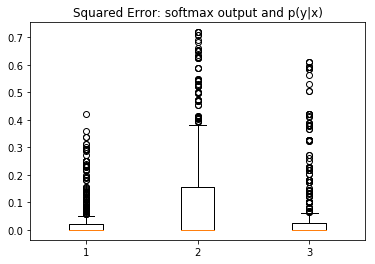

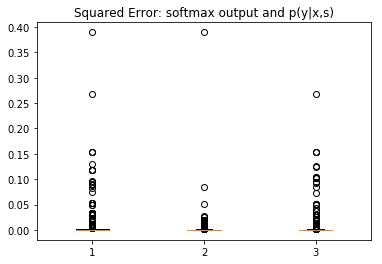

In [13]:
# # multiple box plots on one figure
plt.figure()
plt.boxplot(diff_conv)
plt.title('Squared Error: softmax output and p(y|x)')
plt.show()

plt.figure()
plt.boxplot(diff_lacz)
plt.title('Squared Error: softmax output and p(y|x,s)')
plt.show()

To Do:
    1. Experiment with different proporation of unseen: 0.1, 0.4, 0.7, 0.91, 0.94, 0.97
    2. Experiment with different variances: var = 7, 9, 11, 13, 15, 17, 19

In [14]:
gu.pyCx.__doc__

'\n        Posterior p(y|x)\n        '

In [15]:
gu.pyCx(0, gs.Test_Data['x'][0,:])

0.77309305340255208

In [16]:
gs.Test_Data['x'][0,:]

array([-1.,  0.])

In [17]:
conv = gu.pyCx(0, np.array([4,5])); conv

0.0097353111991354616

In [18]:
lc = gu.pyCxs(0, np.array([4,5])); lc

0.11915747848386597

In [19]:
_yk = model.predict(np.array([[4,5]]))
_yk

array([[ 0.21915616,  0.77340001,  0.00744388]], dtype=float32)

In [20]:
print(_yk[0,0] - conv, _yk[0,0] - lc)

0.209420849752 0.0999986824668
